In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy import stats

batch1 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

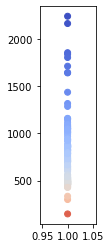

In [2]:
color=[]
cycle_=[]
plt.figure(figsize=(1,4))
for i,j in enumerate(bat_dict.keys()):
    sortcycle=bat_dict[j]['cycle_life']
    cycle_.append(sortcycle.tolist())
    c=(np.log10(sortcycle)-2)/(np.log10(2300)-2)
    color.append(c.tolist())

a=np.array(color).ravel()
b=np.array(cycle_).ravel()
chargecolor=cm.coolwarm_r(a)
plt.scatter(np.ones(len(a)),b,c=cm.coolwarm_r(a))

In [3]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [5]:
def Z_score(Train,prim_test,secondary):
    Z1=(Train-np.mean(Train))/np.std(Train)
    Z2=(prim_test-np.mean(Train))/np.std(Train)
    Z3=(secondary-np.mean(Train))/np.std(Train)
    return Z1, Z2, Z3

In [21]:
Test_var=[]
test_Cycle_life=[]
Train_var=[]
train_Cycle_life=[]
Sec_var=[]
sec_Cycle_life=[]

for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue    
    if i in train_ind :
        Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
        diff=Qdlin100-Qdlin10
        var=np.log10(np.abs(np.var(diff)))
        Train_var.append(var)
        train_Cycle_life.append(bat_dict[j]['cycle_life'][0][0])
        
    if i in test_ind :
        Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
        diff=Qdlin100-Qdlin10
        var=np.log10(np.abs(np.var(diff)))
        Test_var.append(var)
        test_Cycle_life.append(bat_dict[j]['cycle_life'][0][0])
            
    if i in secondary_test_ind:
        Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
        diff=Qdlin100-Qdlin10
        var=np.log10(np.abs(np.var(diff)))
        Sec_var.append(var)
        sec_Cycle_life.append(bat_dict[j]['cycle_life'][0][0])
        
Test_var=np.array(Test_var).reshape(-1,1)
Test_Cycle_life=np.log10(test_Cycle_life).ravel() 

Train_Cycle_life=np.log10(train_Cycle_life).ravel() 
Train_var=np.array(Train_var).reshape(-1,1)

Sec_var=np.array(Sec_var).reshape(-1,1)
sec_Cycle_life=np.log10(sec_Cycle_life).ravel() 

Z1_train,Z1_test,Z1_sec=Z_score(Train_var,Test_var,Sec_var)

In [22]:
#train,primary, secondary data 만들기
Train=Z1_train
Test=Z1_test
Sec=Z1_sec
#train, primary, secondary 정답 데이터 만들기
label_train=Train_Cycle_life
label_test=Test_Cycle_life
label_sec=sec_Cycle_life

In [23]:
Train.shape,Test.shape,Sec.shape

((41, 1), (42, 1), (40, 1))

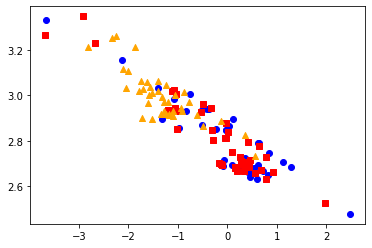

In [24]:
plt.scatter(Z1_train,Train_Cycle_life,color='blue',marker='o',label='train')
plt.scatter(Z1_test,Test_Cycle_life,color='red',marker='s',label='primary test')
plt.scatter(Z1_sec,sec_Cycle_life,color='orange',marker='^',label='secondary test')

# 스케일이 주의 할 것 . log10(abs(var)) 이다.  재현하는 논문에서도 law 데이터 scatter를 보면 log-log plot임을 주의하자.

In [25]:
from sklearn.linear_model import ElasticNetCV
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
from sklearn.metrics import mean_squared_error

reg = ElasticNetCV(cv=4).fit(Train,label_train)
print('ElasticNet CV alpha:',reg.alpha_)
print('ElasticNet CV coefficient:',reg.coef_)
print('ElasticNet CV intercept:',reg.intercept_)

ElasticNetcv=reg.predict(Train)
rmseElasticNetcv=np.sqrt(mean_squared_error(10**label_train,10**ElasticNetcv))
print('RMSE','           ','MAPE')
print(rmseElasticNetcv,MAPE(10**label_train,10**ElasticNetcv))
print('\n')
ElasticNetcv2=reg.predict(Test)
rmseElasticNetcv2=np.sqrt(mean_squared_error(10**label_test,10**ElasticNetcv2))
print('RMSE','           ','MAPE')
print(rmseElasticNetcv2,MAPE(10**label_test,10**ElasticNetcv2))
print('\n')
ElasticNetcv3=reg.predict(Sec)
rmseElasticNetcv3=np.sqrt(mean_squared_error(10**label_sec,10**ElasticNetcv3))
print('RMSE','           ','MAPE')
print(rmseElasticNetcv3,MAPE(10**label_sec,10**ElasticNetcv3))

ElasticNet CV alpha: 0.0002922628074490315
ElasticNet CV coefficient: [-0.14596394]
ElasticNet CV intercept: 2.7939698976436373
RMSE             MAPE
103.63016318893422 14.132253563778782


RMSE             MAPE
138.40320335160575 13.194793001199873


RMSE             MAPE
169.96062649156408 11.069995870646801


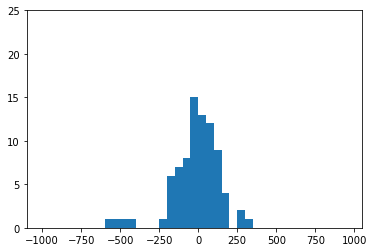

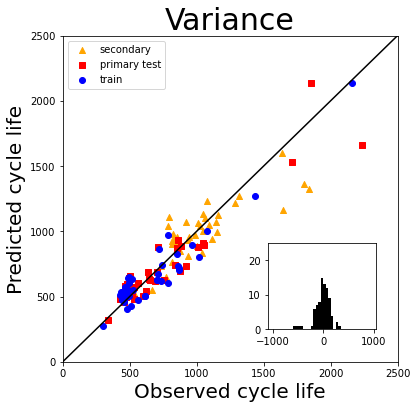

In [39]:
# ElasticNet
s_res=(10**ElasticNetcv3)-(10**label_sec)
p_res=(10**ElasticNetcv2)-(10**label_test)


s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])


bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,25)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_sec,10**ElasticNetcv3,color='orange',marker='^',label='secondary')
plt.scatter(10**label_test,10**ElasticNetcv2,color='red',marker='s',label='primary test')
plt.scatter(10**label_train,10**ElasticNetcv,color='blue',marker='o',label='train')
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.axis([0,2500,0,2500])
plt.title('Variance',size=30)
plt.legend()
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,25)
ax_sub.hist(his,bins,color='black')
plt.show()

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09741112439047189, tolerance: 0.00010703521221153374
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

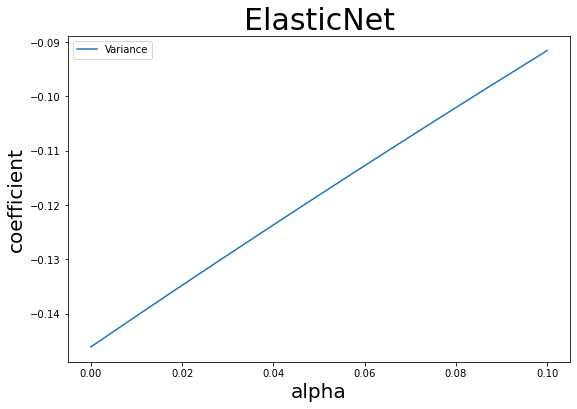

In [29]:
Y=[]
X=[]
from sklearn.linear_model import ElasticNet
plt.figure(figsize=(9,6))
for i in np.linspace(0,0.1,1000):
    regrplot=ElasticNet(alpha=i)
    regrplot.fit(Train,label_train)
    Y.append(regrplot.coef_)
    X.append(i)
Y_=np.array(Y)    
plt.plot(X,Y_,label='Variance')
plt.title('ElasticNet',size=30)
plt.xlabel('alpha',size=20)
plt.ylabel('coefficient',size=20)
plt.legend()
plt.show

# 규제된 선형회귀 코드를 이용하게 되면 alpha 값이 0에 가까워서 일반 LinearRegression을 사용하기를 충고받는다.

In [31]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=4).fit(Train,label_train)
print('Lasso CV alpha:',reg.alpha_)
print('Lasso CV coefficient:',reg.coef_)
print('Lasso CV intercept:',reg.intercept_)

Lassocv=reg.predict(Train)
rmseLassocv=np.sqrt(mean_squared_error(10**label_train,10**Lassocv))
print('RMSE','           ','MAPE')
print(rmseLassocv,MAPE(10**label_train,10**Lassocv))
print('\n')
Lassocv2=reg.predict(Test)
rmseLassocv2=np.sqrt(mean_squared_error(10**label_test,10**Lassocv2))
print('RMSE','           ','MAPE')
print(rmseLassocv2,MAPE(10**label_test,10**Lassocv2))
print('\n')
Lassocv3=reg.predict(Sec)
rmseLassocv3=np.sqrt(mean_squared_error(10**label_sec,10**Lassocv3))
print('RMSE','           ','MAPE')
print(rmseLassocv3,MAPE(10**label_sec,10**Lassocv3))

Lasso CV alpha: 0.00014613140372451573
Lasso CV coefficient: [-0.14598527]
Lasso CV intercept: 2.7939698976436373
RMSE             MAPE
103.62259283366626 14.131259187096745


RMSE             MAPE
138.38968797076586 13.194712835250291


RMSE             MAPE
169.9410956975352 11.070072670957018


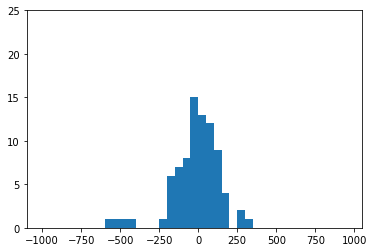

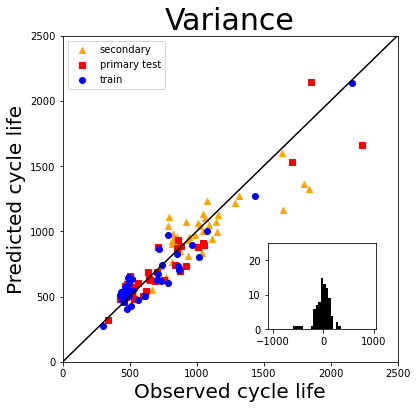

In [40]:
# Lasso
s_res=(10**Lassocv3)-(10**label_sec)
p_res=(10**Lassocv2)-(10**label_test)


s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])


bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,25)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_sec,10**Lassocv3,color='orange',marker='^',label='secondary')
plt.scatter(10**label_test,10**Lassocv2,color='red',marker='s',label='primary test')
plt.scatter(10**label_train,10**Lassocv,color='blue',marker='o',label='train')
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.axis([0,2500,0,2500])
plt.title('Variance',size=30)
plt.legend()
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,25)
ax_sub.hist(his,bins,color='black')
plt.show()

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09741112439047189, tolerance: 0.00010703521221153374
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

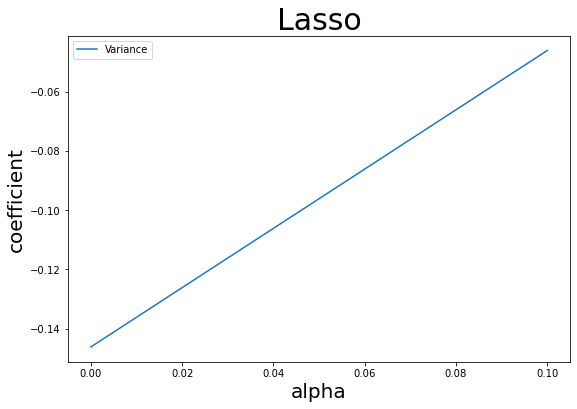

In [35]:
Y=[]
X=[]
from sklearn.linear_model import Lasso
plt.figure(figsize=(9,6))
for i in np.linspace(0,0.1,1000):
    regrplot=Lasso(alpha=i)
    regrplot.fit(Train,label_train)
    Y.append(regrplot.coef_)
    X.append(i)
Y_=np.array(Y)    
plt.plot(X,Y_[:,0],label='Variance')
plt.title('Lasso',size=30)
plt.xlabel('alpha',size=20)
plt.ylabel('coefficient',size=20)
plt.legend()
plt.show

In [36]:
from sklearn.linear_model import RidgeCV
reg = RidgeCV(cv=4).fit(Train,label_train)
print('Ridge CV alpha:',reg.alpha_)
print('Ridge CV coefficient:',reg.coef_)
print('Ridge CV intercept:',reg.intercept_)

Ridgecv=reg.predict(Train)
rmseRidgecv=np.sqrt(mean_squared_error(10**label_train,10**Ridgecv))
print('RMSE','           ','MAPE')
print(rmseRidgecv,MAPE(10**label_train,10**Ridgecv))
print('\n')
Ridgecv2=reg.predict(Test)
rmseRidgecv2=np.sqrt(mean_squared_error(10**label_test,10**Ridgecv2))
print('RMSE','           ','MAPE')
print(rmseRidgecv2,MAPE(10**label_test,10**Ridgecv2))
print('\n')
Ridgecv3=reg.predict(Sec)
rmseRidgecv3=np.sqrt(mean_squared_error(10**label_sec,10**Ridgecv3))
print('RMSE','           ','MAPE')
print(rmseRidgecv3,MAPE(10**label_sec,10**Ridgecv3))

Ridge CV alpha: 0.1
Ridge CV coefficient: [-0.14577585]
Ridge CV intercept: 2.7939698976436373
RMSE             MAPE
103.6987706009886 14.141015724520217


RMSE             MAPE
138.52427792078947 13.195500261871423


RMSE             MAPE
170.13445133677484 11.069316915335184


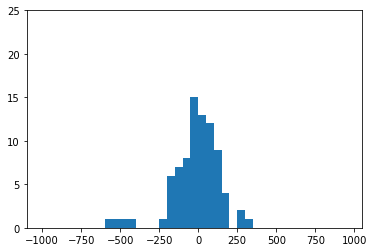

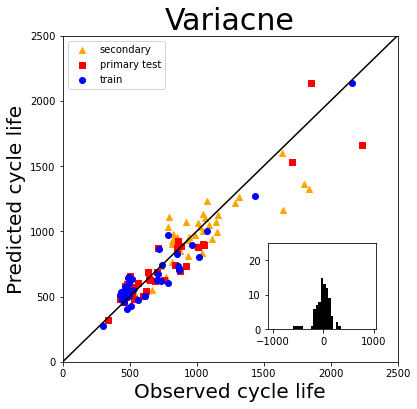

In [41]:
# Ridge
s_res=(10**Ridgecv3)-(10**label_sec)
p_res=(10**Ridgecv2)-(10**label_test)


s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])


bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,25)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_sec,10**Ridgecv3,color='orange',marker='^',label='secondary')
plt.scatter(10**label_test,10**Ridgecv2,color='red',marker='s',label='primary test')
plt.scatter(10**label_train,10**Ridgecv,color='blue',marker='o',label='train')
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.axis([0,2500,0,2500])
plt.title('Variacne',size=30)
plt.legend()
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,25)
ax_sub.hist(his,bins,color='black')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

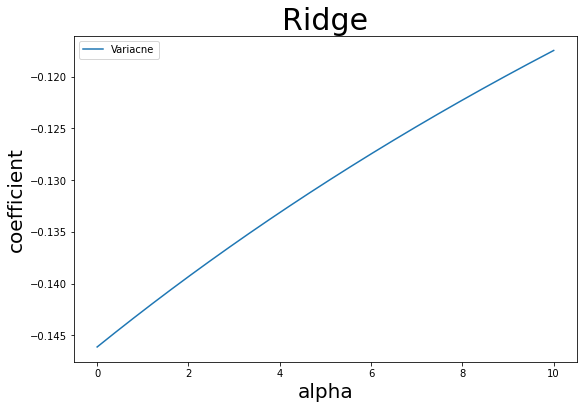

In [38]:
Y=[]
X=[]
from sklearn.linear_model import Ridge
plt.figure(figsize=(9,6))
for i in np.linspace(0,10,1000):
    regrplot=Ridge(alpha=i)
    regrplot.fit(Train,label_train)
    Y.append(regrplot.coef_)
    X.append(i)
Y_=np.array(Y)    
plt.plot(X,Y_[:,0],label='Variacne')
plt.title('Ridge',size=30)
plt.xlabel('alpha',size=20)
plt.ylabel('coefficient',size=20)
plt.legend()
plt.show